# CKD Risk Prediction — Training

This notebook trains and compares baseline ML models using the **canonical base-paper feature set only**:

- `hemo, sc, al, htn, age, dm`

Key constraints enforced throughout:

- `dm` and `htn` are **binary flags**: values are coerced to `{0,1}`
- No one-hot encoded flag columns are allowed (e.g., `dm_0.0`, `dm_1.0`, `htn_0.0`, `htn_1.0`)
- Feature order is **strictly**: `['hemo','sc','al','htn','age','dm']`

Metrics reported: ROC-AUC, Precision, Recall, F1.


In [1]:
from __future__ import annotations

import os
import sys
from pathlib import Path

import joblib
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
 )


def _find_project_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'src').exists():
            return p
    return start


PROJECT_ROOT = _find_project_root(Path.cwd().resolve())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Ensure relative paths (dataset/, data/, results/, models/) work reliably
os.chdir(PROJECT_ROOT)

from src.cleaning import apply_clinical_bounds, model_based_impute  # noqa: E402
from src.config import PREPROC_DIR, SPLIT_DIR, RESULTS_DIR  # noqa: E402
from src.canonical import (  # noqa: E402
    CANONICAL_FEATURES,
    CanonicalPreprocessor,
    assert_canonical_schema,
    forbid_onehot_residuals,
 )
from src.utils import ensure_dir, save_json  # noqa: E402

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

RANDOM_STATE = 0
print('PROJECT_ROOT =', PROJECT_ROOT)
print('CWD          =', Path.cwd())
print('CANONICAL_FEATURES =', CANONICAL_FEATURES)


PROJECT_ROOT = E:\docs\FYP\demo\CKD_Risk_Prediction
CWD          = E:\docs\FYP\demo\CKD_Risk_Prediction
CANONICAL_FEATURES = ['hemo', 'sc', 'al', 'htn', 'age', 'dm']


## 1) Load cleaned/split datasets (raw + preprocessed)

This notebook expects you have already run the cleaning step:

- `python src/cleaning.py`

That should create:
- `data/processed/splits/X_train_raw.csv`, `X_test_raw.csv`, `y_train.csv`, `y_test.csv`
- `data/processed/preprocessed/X_train_preproc.csv`, `X_test_preproc.csv` (optional sanity check)


In [2]:
import subprocess

split_dir = Path(SPLIT_DIR)

required = [
    split_dir / 'X_train_raw.csv',
    split_dir / 'X_test_raw.csv',
    split_dir / 'y_train.csv',
    split_dir / 'y_test.csv',
]
missing = [p for p in required if not p.exists()]

if missing:
    print('Split files not found. Running cleaning step to regenerate them...')
    cmd = [sys.executable, str(PROJECT_ROOT / 'src' / 'cleaning.py')]
    proc = subprocess.run(cmd, cwd=str(PROJECT_ROOT), capture_output=True, text=True)
    print('cleaning.py return code:', proc.returncode)
    if proc.stdout:
        print('--- cleaning.py stdout ---')
        print(proc.stdout)
    if proc.stderr:
        print('--- cleaning.py stderr ---')
        print(proc.stderr)
    if proc.returncode != 0:
        raise RuntimeError('cleaning.py failed. See stdout/stderr above.')

missing = [p for p in required if not p.exists()]
if missing:
    raise FileNotFoundError(
        'Missing cleaned/split files even after running cleaning.\n\nMissing:\n'
        + '\n'.join(str(p) for p in missing)
    )

X_train_raw = pd.read_csv(split_dir / 'X_train_raw.csv')
X_test_raw = pd.read_csv(split_dir / 'X_test_raw.csv')
y_train = pd.read_csv(split_dir / 'y_train.csv')['target'].to_numpy()
y_test = pd.read_csv(split_dir / 'y_test.csv')['target'].to_numpy()

print('Raw train shape:', X_train_raw.shape)
print('Raw test shape :', X_test_raw.shape)
print('Train positive rate:', float(np.mean(y_train)))
print('Test  positive rate:', float(np.mean(y_test)))

print('\nMissingness (train, top 15):')
miss = X_train_raw.isna().mean().sort_values(ascending=False)
display(miss.head(15))

# Optional sanity-check: preprocessed matrices exist
preproc_dir = Path(PREPROC_DIR)
if (preproc_dir / 'X_train_preproc.csv').exists():
    X_train_preproc = pd.read_csv(preproc_dir / 'X_train_preproc.csv')
    X_test_preproc = pd.read_csv(preproc_dir / 'X_test_preproc.csv')
    print('\nPreprocessed train shape:', X_train_preproc.shape)
    print('Preprocessed test shape :', X_test_preproc.shape)


Raw train shape: (280, 24)
Raw test shape : (120, 24)
Train positive rate: 0.625
Test  positive rate: 0.625

Missingness (train, top 15):


rbc     0.389286
rc      0.310714
wc      0.246429
pot     0.239286
sod     0.235714
pc      0.167857
pcv     0.167857
su      0.139286
sg      0.135714
al      0.132143
hemo    0.125000
bgr     0.114286
bu      0.064286
sc      0.053571
bp      0.028571
dtype: float64


Preprocessed train shape: (280, 6)
Preprocessed test shape : (120, 6)


## 2) Canonical feature set (base-paper)

We train and explain models strictly in the canonical feature space:

- `['hemo','sc','al','htn','age','dm']`

We validate that these features exist in the raw split columns before proceeding.

In [3]:
# Canonical features (single source of truth)
print('Canonical schema:', CANONICAL_FEATURES)

available = set(X_train_raw.columns)
missing = [c for c in CANONICAL_FEATURES if c not in available]
if missing:
    raise ValueError(f'Missing canonical columns in raw train split: {missing}')

print('OK: all canonical columns exist in raw splits.')


Canonical schema: ['hemo', 'sc', 'al', 'htn', 'age', 'dm']
OK: all canonical columns exist in raw splits.


## 3) Canonical preprocessing on raw data (impute + bounds + canonical schema)

We build one canonical representation used for training and evaluation:

- Select only the canonical features
- Coerce `dm` and `htn` to `{0,1}`
- Impute missing values (learned on train only)
- Enforce strict feature order and ban any one-hot residuals

In [4]:
# Train-only learned regression imputation (paper-aligned)
X_train_learn = X_train_raw.copy()
X_train_imp = model_based_impute(X_train_learn, X_train_raw)
X_test_imp = model_based_impute(X_train_learn, X_test_raw)

# Clip bounds after imputation
X_train_imp = apply_clinical_bounds(X_train_imp)
X_test_imp = apply_clinical_bounds(X_test_imp)

print('After imputation/bounds:')
print('Train missingness:', float(X_train_imp.isna().mean().mean()))
print('Test  missingness:', float(X_test_imp.isna().mean().mean()))

# Canonical preprocessing (NO scaling, NO one-hot; binary flags only)
canonical_preproc = CanonicalPreprocessor().fit(X_train_imp)
X_train_canon = canonical_preproc.transform(X_train_imp)
X_test_canon = canonical_preproc.transform(X_test_imp)

# Required safety checks
forbid_onehot_residuals(list(X_train_canon.columns))
forbid_onehot_residuals(list(X_test_canon.columns))
assert_canonical_schema(X_train_canon)
assert_canonical_schema(X_test_canon)

print('Canonical train shape:', X_train_canon.shape)
print('Canonical test shape :', X_test_canon.shape)
print('Unique dm values (train):', sorted(pd.unique(X_train_canon['dm'])))
print('Unique htn values (train):', sorted(pd.unique(X_train_canon['htn'])))


After imputation/bounds:
Train missingness: 0.025446428571428568
Test  missingness: 0.021874999999999995
Canonical train shape: (280, 6)
Canonical test shape : (120, 6)
Unique dm values (train): [np.int64(0), np.int64(1)]
Unique htn values (train): [np.int64(0), np.int64(1)]


## 4–6) Train/evaluate models

We evaluate LR and RF (and XGB if installed) using the **canonical feature representation** (same columns, order, and dtypes for real and augmented training).

In [5]:
def _metrics(y_true: np.ndarray, y_prob: np.ndarray) -> dict[str, float]:
    y_pred = (y_prob >= 0.5).astype(int)
    return {
        'roc_auc': float(roc_auc_score(y_true, y_prob)),
        'precision': float(precision_score(y_true, y_pred, zero_division=0)),
        'recall': float(recall_score(y_true, y_pred, zero_division=0)),
        'f1': float(f1_score(y_true, y_pred, zero_division=0)),
    }


def evaluate_canonical() -> pd.DataFrame:
    # Required safety check
    assert_canonical_schema(X_train_canon)
    assert_canonical_schema(X_test_canon)

    results: list[dict[str, object]] = []

    # Logistic Regression (aligned with src/train.py)
    lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=RANDOM_STATE)
    lr.fit(X_train_canon, y_train)
    y_prob = lr.predict_proba(X_test_canon)[:, 1]
    results.append({'feature_set': 'canonical', 'n_features': len(CANONICAL_FEATURES), 'model': 'lr', **_metrics(y_test, y_prob)})

    # Random Forest (aligned with src/train.py)
    rf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=RANDOM_STATE)
    rf.fit(X_train_canon, y_train)
    y_prob = rf.predict_proba(X_test_canon)[:, 1]
    results.append({'feature_set': 'canonical', 'n_features': len(CANONICAL_FEATURES), 'model': 'rf', **_metrics(y_test, y_prob)})

    # XGBoost (optional)
    try:
        from xgboost import XGBClassifier

        xgb = XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.05,
            random_state=RANDOM_STATE,
            eval_metric='logloss',
        )
        xgb.fit(X_train_canon, y_train)
        y_prob = xgb.predict_proba(X_test_canon)[:, 1]
        results.append({'feature_set': 'canonical', 'n_features': len(CANONICAL_FEATURES), 'model': 'xgb', **_metrics(y_test, y_prob)})
    except Exception as e:
        print('XGBoost not available or failed to run:', repr(e))

    return pd.DataFrame(results)


In [6]:
results_df = evaluate_canonical()

# Compact readable table
show_cols = ['feature_set','n_features','model','roc_auc','f1','precision','recall']
results_view = results_df[show_cols].copy()
results_view = results_view.sort_values(['roc_auc'], ascending=[False])

display(results_view.round(4))


,feature_set,n_features,model,roc_auc,f1,precision,recall
1,canonical,6,rf,1.0000,0.9933,1.0000,0.9867
2,canonical,6,xgb,0.9988,0.9799,0.9865,0.9733
0,canonical,6,lr,0.9979,0.9510,1.0000,0.9067


In [7]:
from sklearn.model_selection import StratifiedKFold


def cv_no_calibration_canonical(
    X_raw_full: pd.DataFrame,
    y: np.ndarray,
    n_splits: int = 5,
    random_state: int = 0,
 ) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    rows: list[dict[str, object]] = []

    def _eval_model(model_name: str):
        fold_metrics: list[dict[str, float]] = []

        for tr_idx, va_idx in skf.split(X_raw_full, y):
            X_tr_raw_full = X_raw_full.iloc[tr_idx].copy()
            y_tr = y[tr_idx]
            X_va_raw_full = X_raw_full.iloc[va_idx].copy()
            y_va = y[va_idx]

            # Fold-local regression imputation learned from fold-train only
            X_tr_learn = X_tr_raw_full.copy()
            X_tr_imp = model_based_impute(X_tr_learn, X_tr_raw_full)
            X_va_imp = model_based_impute(X_tr_learn, X_va_raw_full)
            X_tr_imp = apply_clinical_bounds(X_tr_imp)
            X_va_imp = apply_clinical_bounds(X_va_imp)

            # Fold-local canonical preprocessing
            preproc = CanonicalPreprocessor().fit(X_tr_imp)
            X_tr = preproc.transform(X_tr_imp)
            X_va = preproc.transform(X_va_imp)

            assert_canonical_schema(X_tr)
            assert_canonical_schema(X_va)

            if model_name == 'lr':
                base = LogisticRegression(
                    solver='liblinear',
                    C=1.0,
                    max_iter=1000,
                    random_state=random_state,
                )
            elif model_name == 'rf':
                base = RandomForestClassifier(
                    n_estimators=200,
                    max_depth=7,
                    random_state=random_state,
                )
            elif model_name == 'xgb':
                from xgboost import XGBClassifier

                base = XGBClassifier(
                    n_estimators=200,
                    max_depth=5,
                    learning_rate=0.05,
                    random_state=random_state,
                    eval_metric='logloss',
                )
            else:
                raise ValueError(model_name)

            base.fit(X_tr, y_tr)
            y_prob = base.predict_proba(X_va)[:, 1]
            fold_metrics.append(_metrics(y_va, y_prob))

        df = pd.DataFrame(fold_metrics)
        out: dict[str, object] = {
            'feature_set': 'canonical',
            'n_features': len(CANONICAL_FEATURES),
            'model': model_name,
            'cv_folds': float(n_splits),
        }
        for m in ['roc_auc', 'precision', 'recall', 'f1']:
            out[f'{m}_mean'] = float(df[m].mean())
            out[f'{m}_std'] = float(df[m].std(ddof=0))
        rows.append(out)

    for name in ['lr', 'rf', 'xgb']:
        try:
            _eval_model(name)
        except Exception as e:
            if name == 'xgb':
                print('Skipping XGB in CV:', repr(e))
            else:
                raise

    return pd.DataFrame(rows)


cv_df = cv_no_calibration_canonical(X_train_raw, y_train, n_splits=5, random_state=RANDOM_STATE)

# Print compactly (mean ± std)
for _, r in cv_df.iterrows():
    print(
        f"CV 5-fold {r['model'].upper()} (canonical): "
        f"AUC {r['roc_auc_mean']:.4f}±{r['roc_auc_std']:.4f}, "
        f"F1 {r['f1_mean']:.4f}±{r['f1_std']:.4f}, "
        f"Precision {r['precision_mean']:.4f}±{r['precision_std']:.4f}, "
        f"Recall {r['recall_mean']:.4f}±{r['recall_std']:.4f}"
    )

display(cv_df.round(4))


CV 5-fold LR (canonical): AUC 0.9916±0.0080, F1 0.9644±0.0121, Precision 1.0000±0.0000, Recall 0.9314±0.0229
CV 5-fold RF (canonical): AUC 0.9965±0.0035, F1 0.9747±0.0208, Precision 0.9617±0.0272, Recall 0.9886±0.0229
CV 5-fold XGB (canonical): AUC 0.9931±0.0074, F1 0.9601±0.0103, Precision 0.9612±0.0272, Recall 0.9600±0.0229


,feature_set,n_features,model,cv_folds,roc_auc_mean,roc_auc_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,canonical,6,lr,5.0,0.9916,0.0080,1.0000,0.0000,0.9314,0.0229,0.9644,0.0121
1,canonical,6,rf,5.0,0.9965,0.0035,0.9617,0.0272,0.9886,0.0229,0.9747,0.0208
2,canonical,6,xgb,5.0,0.9931,0.0074,0.9612,0.0272,0.9600,0.0229,0.9601,0.0103


## 6b) 5-fold cross-validation — final 6-feature set

This evaluates **LR**, **RF**, and **XGB** using strict fold-local preprocessing:

- Imputation is learned on each fold's train split only.
- Bounds clipping is applied after imputation.
- Preprocessor (scale/encode) is fit on each fold's train split only.

We report mean ± std across 5 folds on the training split (`X_train_raw`, `y_train`).

## 7) Compare results (single table + quick plots)

Below is a simple visual summary of ROC-AUC.

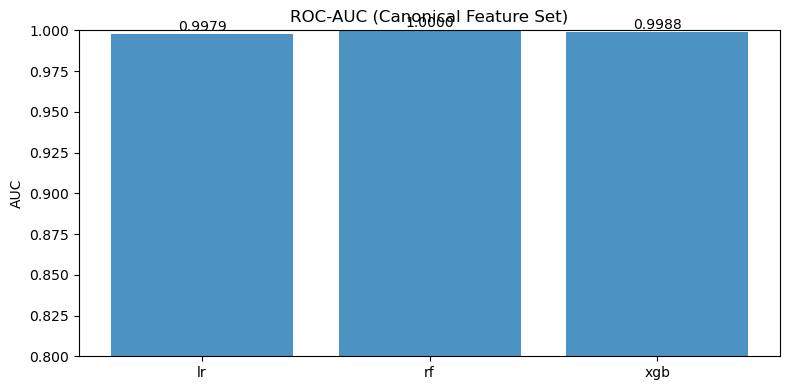

In [10]:
import matplotlib.pyplot as plt

plot_df = results_df.copy()

# AUC bar plot
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar([m for m in plot_df['model']], plot_df['roc_auc'], alpha=0.8)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=10)

ax.set_title('ROC-AUC (Canonical Feature Set)')
ax.set_ylabel('AUC')
ax.set_ylim((0.8, 1.0))
plt.tight_layout()
plt.show()


## 8) Confusion Matrices

Plot confusion matrices for all models on the test set.

=== Canonical Confusion Matrices ===


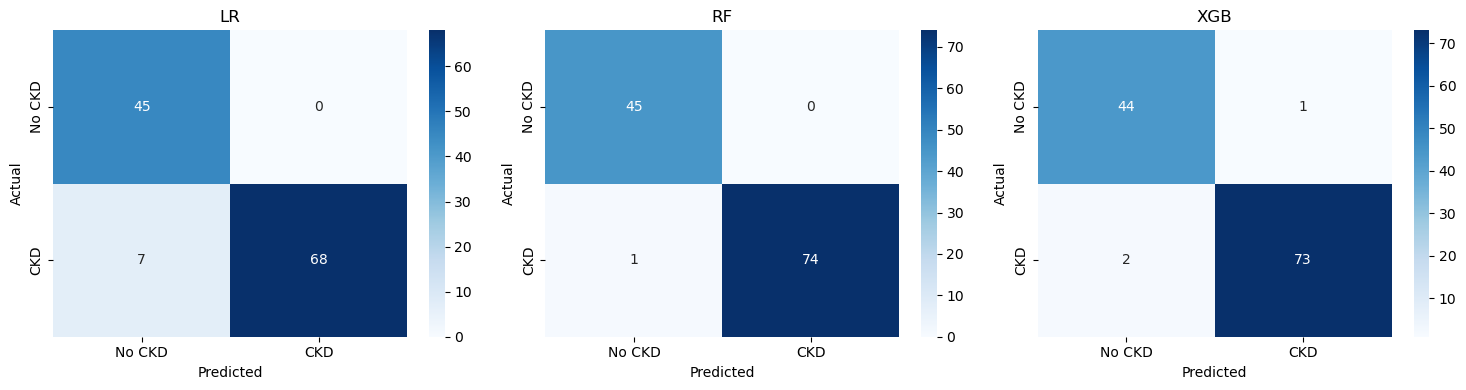

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrices():
    """Plot confusion matrices for LR, RF, and XGB on test set (canonical features)."""
    assert_canonical_schema(X_train_canon)
    assert_canonical_schema(X_test_canon)

    models_to_plot = []

    # Logistic Regression
    lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=RANDOM_STATE)
    lr.fit(X_train_canon, y_train)
    models_to_plot.append(('LR', lr.predict(X_test_canon)))

    # Random Forest
    rf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=RANDOM_STATE)
    rf.fit(X_train_canon, y_train)
    models_to_plot.append(('RF', rf.predict(X_test_canon)))

    # XGBoost (optional)
    try:
        from xgboost import XGBClassifier
        xgb = XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.05,
            random_state=RANDOM_STATE,
            eval_metric='logloss',
        )
        xgb.fit(X_train_canon, y_train)
        models_to_plot.append(('XGB', xgb.predict(X_test_canon)))
    except Exception as e:
        print(f'XGBoost not available: {repr(e)}')

    n_models = len(models_to_plot)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))
    if n_models == 1:
        axes = [axes]

    for ax, (model_name, y_pred) in zip(axes, models_to_plot):
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            ax=ax,
            cbar=True,
            xticklabels=['No CKD', 'CKD'],
            yticklabels=['No CKD', 'CKD'],
        )
        ax.set_title(f'{model_name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    plt.tight_layout()
    plt.show()


print('=== Canonical Confusion Matrices ===')
plot_confusion_matrices()


## 9) Save trained models (6-feature set)

Save the trained models with 6 features to the `models/` folder.

In [12]:
# Train and save models (canonical feature set)
models_dir = PROJECT_ROOT / 'models'
ensure_dir(models_dir)

# Save canonical preprocessor alongside models for inference/SHAP alignment
joblib.dump(canonical_preproc, models_dir / 'preprocessor.pkl')
print(f'Saved: {models_dir / "preprocessor.pkl"}')

assert_canonical_schema(X_train_canon)
assert_canonical_schema(X_test_canon)

# Train and save Logistic Regression
print('Training and saving LR model...')
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=RANDOM_STATE)
lr.fit(X_train_canon, y_train)
joblib.dump(lr, models_dir / 'lr.joblib')
print(f'Saved: {models_dir / "lr.joblib"}')

# Train and save Random Forest
print('Training and saving RF model...')
rf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=RANDOM_STATE)
rf.fit(X_train_canon, y_train)
joblib.dump(rf, models_dir / 'rf.joblib')
print(f'Saved: {models_dir / "rf.joblib"}')

# Train and save XGBoost
try:
    from xgboost import XGBClassifier
    print('Training and saving XGB model...')
    xgb = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
    )
    xgb.fit(X_train_canon, y_train)
    joblib.dump(xgb, models_dir / 'xgb.joblib')
    print(f'Saved: {models_dir / "xgb.joblib"}')
except Exception as e:
    print(f'XGBoost not available: {repr(e)}')

print('\n✓ All models saved successfully!')


Saved: E:\docs\FYP\demo\CKD_Risk_Prediction\models\preprocessor.pkl
Training and saving LR model...
Saved: E:\docs\FYP\demo\CKD_Risk_Prediction\models\lr.joblib
Training and saving RF model...
Saved: E:\docs\FYP\demo\CKD_Risk_Prediction\models\rf.joblib
Training and saving XGB model...
Saved: E:\docs\FYP\demo\CKD_Risk_Prediction\models\xgb.joblib

✓ All models saved successfully!
